In [38]:
import requests
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2025)

# I - X-ray tomography

Question 1: Download the data.

In [36]:
dataH, datax = loadmat("data/H.mat"), loadmat("data/x.mat")
H = dataH['H'].toarray()
x = datax['x']
M, N = H.shape
print(f"M = {M}, N = {N}")
print("x has good shape" if N == x.size else  "x has bad shape")

M = 16200, N = 8100
x has good shape


Question 2: Construct $y$, according to model $(1)$, using $\sigma  = 1$.

In [49]:
noise = np.random.normal(loc = 0, scale = 1, size = M)  # Build some noise
y = np.dot(H, x).reshape(-1) + noise  # Build the y vector

Question 3: Display a 2D version of x and a 2D version of y, also known as sinogram.

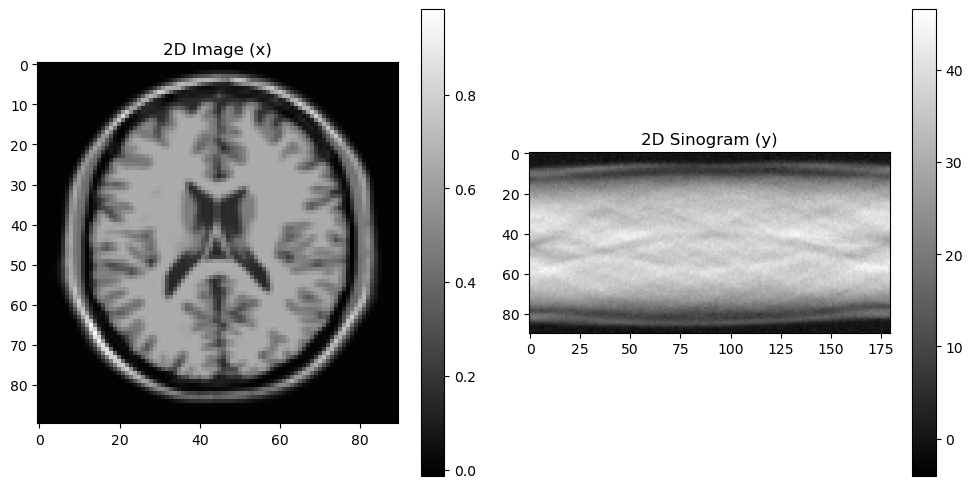

In [50]:
# Reshape to 2D
x_2d = x.reshape((90, 90), order='F')  # Reshape for 2D image
y_2d = y.reshape((90, 180), order='F')  # Reshape for 2D sinogram

# Display the 2D image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(x_2d, cmap='gray')
plt.title("2D Image (x)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y_2d, cmap='gray')
plt.title("2D Sinogram (y)")
plt.colorbar()

plt.tight_layout()
plt.show()

# II - Optimization problem

### Reconstruction Problem: Penalized Least-Squares Criterion

An efficient strategy to address the reconstruction problem is to define **x** as a minimizer of an appropriate cost function **f**. Specifically, we consider the following penalized least-squares criterion:

$$
\forall x \in \mathbb{R}^N, \quad f(x) = \frac{1}{2} \|Hx - y\|^2 + \lambda r(x), \tag{2}
$$

where:
- **$H$** is the system matrix.
- **$y$** is the observed data.
- **$r(x)$** is a regularization function incorporating a priori assumptions to improve robustness against noise.

---

#### Regularization Function

To promote images with smooth regions separated by sharp edges, we define the regularization function as:

$$
\forall x \in \mathbb{R}^N, \quad r(x) = \sum_{n=1}^{2N} \psi([Gx]_n), \tag{3}
$$

Here:
- **$ G \in \mathbb{R}^{2N \times N} $** is a sparse matrix such that $ Gx \in \mathbb{R}^{2N} $ concatenates the horizontal and vertical gradients of the image.
- **$ \psi $** is a potential function, defined as: $\psi(t) = \sqrt{t^2 + \delta}, \quad \delta > 0.$

The parameter **$ \delta $** ensures the differentiability of the regularization function.

---

### Parameter Selection

In the following computations, we will set the parameters as: $\lambda = 0.13, \quad \delta = 0.02$.


In [53]:
lambda_ = 0.13
delta_ = 0.02

Question 1: Download the gradient operator G available in the website.

In [52]:
dataG = loadmat("data/G.mat")
G = dataG['G'].toarray()

Question 2: Give the expression of the gradient $ \nabla f$ at some point $x \in \mathbb{R}^N $. Create a function which gives as an output the gradient of $f$ at some input vector x.

First, $ \forall u \in \mathbb{R}, \text{ } \psi ^{'} (u) = \displaystyle \frac{u}{\delta ^2 \sqrt{1 + \frac{u ^2}{\delta ^2}}}$.

Then, we have : $\forall x \in \mathbb{R}^N, \text{ } \nabla f (x) = H^{\text{T}} (Hx - y) + \lambda \displaystyle \sum _{n=1} ^{2N} \psi ^{'} ( \left[ Gx \right]^{(n)} ) G^{(n)}$

In [64]:
def gradient_psi(u):
    """ Define the gradient of the psi function """
    return u / (delta_ ** 2 * np.sqrt(1 + (u ** 2) / delta_ ** 2))  
def gradient_f(x):
    """ Define the gradient of the f function """
    first = np.dot(H.T, np.dot(H, x).reshape(-1) - y).reshape(-1)  
    G_x = np.dot(G, x).reshape(-1)
    second = lambda_ * np.sum([gradient_psi(G_x[n]) * G[n] for n in range(G_x.size)], axis = 0)
    return first + second

Question 3: Show that a Lipschitz constant of $ \nabla f$ is $L = || H ||^2 + \frac{ \lambda }{\delta ^2} ||G||^2$.

We would like to show the following properties of the gradient of the f function:

$$ \forall x,y \in \mathbb{R}^N, \text{ } || \nabla f (x) - \nabla f (y)|| \leq L || x - y || $$

By the mean value theorem, we have:

$$
\|\nabla f(x) - \nabla f(y)\| \leq \|\nabla^2 f\| \|y - x\|
$$

Therefore, it is sufficient to prove that:

$$
\|\nabla^2 f\| \leq \|H\|^2 + \frac{\lambda}{\delta^2} \|G\|^2
$$

---

### Calculating Derivatives

We calculate the first and second derivatives of \(f\) as follows:

$$
\begin{align}
\nabla f &= H^{ \text{T}}(Hx - y) + \lambda \sum_{n=1} ^{2N} \Psi ^{'} \left( [Gx]^{(n)} \right) G^{(n)} \\ 
\nabla ^2 f &= H^{ \text{T}} H + \lambda \sum_{n=1}^{2N} \Psi ^{''} \left( [Gx]^{(n)} \right) [G^{(n)} G^{(n) \text{T}}]  \\
\end{align}
$$

---

### Properties of the Potential Function

The derivatives of $ \Psi $ are given by:

$$
\begin{align}
\Psi^{\prime}(u) &= \frac{u}{\delta^2 \sqrt{1 + \frac{u^2}{\delta^2}}} \\\\
\Psi^{\prime\prime}(u) &= \frac{\delta^2 \sqrt{1 + \frac{u^2}{\delta^2}} - u \left[\frac{\delta^2 u}{\delta^2 \sqrt{1 + \frac{u^2}{\delta^2}}}\right]}{\delta^4 \left(1 + \frac{u^2}{\delta^2}\right)} \\\\
&= \frac{\delta^2 \left(1 + \frac{u^2}{\delta^2}\right) - u^2}{\delta^4 \left(1 + \frac{u^2}{\delta^2}\right)}
\end{align}
$$

The maximum of $ \Psi^{\prime\prime}$ is reached when $u = 0$. Thus:

$$
\Psi^{\prime\prime}(0) = \frac{1}{\delta^2}
$$

---

### Substituting into the Expression for \(\nabla^2 f\)

We obtain:

$$
\nabla^2 f = H^{\top}H + \frac{\lambda}{\delta^2} G^{\top}G
$$

---

### Bounding the Norm

Calculating the norm on both sides, we have:

$$
\begin{align}
\|\nabla^2 f\|_2 &= \|H^{\top}H\|_2 + \frac{\lambda}{\delta^2} \|G^{\top}G\|_2 \\\\
&\leq \|H\|_2 \|H^{\top}\|_2 + \frac{\lambda}{\delta^2} \|G\|_2 \|G\|_2 \\\\
&= \|H\|_2^2 + \frac{\lambda}{\delta^2} \|G\|_2^2
\end{align}
$$

In [65]:
grad = gradient_f(x)
grad

array([-0.40641114,  1.70289335, -2.0765273 , ..., -4.81935987,
       -4.65834139,  6.97671337])

In [66]:
grad.shape

(8100,)